In [1]:
# import the necessary packages
import import_ipynb
import config
from dataset import SegmentationDataset
from model import UNet
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

importing Jupyter notebook from config.ipynb
importing Jupyter notebook from dataset.ipynb
importing Jupyter notebook from model.ipynb


In [2]:
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))

In [3]:
split = train_test_split(imagePaths, maskPaths,
    test_size=config.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [4]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
     transforms.Resize((config.INPUT_IMAGE_HEIGHT,
        config.INPUT_IMAGE_WIDTH)),
        transforms.ToTensor()])

In [5]:
# create the train datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
    transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)

In [6]:
# create the training data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)
    #num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
    batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)
    #num_workers=os.cpu_count())

In [7]:
# initialize our UNet model
unet = UNet().to(config.DEVICE)
# initialize loss function and optimizer

lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}
P ={"x":[], 'y1':[]}

In [8]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        ##(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
        P['x'].append(x)
        P['y1'].append(pred)
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            print(y.shape)
            ##(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
            P['x'].append(x)
            P['y1'].append(pred)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

[INFO] training the network...
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 1, 128, 128])


  1%|▌                                                                             | 1/150 [08:23<20:50:39, 503.62s/it]

[INFO] EPOCH: 1/150
Train loss: 0.621009, Validation loss: 0.5471
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  1%|█                                                                             | 2/150 [16:44<20:37:39, 501.75s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 2/150
Train loss: 0.566505, Validation loss: 0.5192
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  2%|█▌                                                                            | 3/150 [24:53<20:15:32, 496.14s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 3/150
Train loss: 0.555968, Validation loss: 0.5116
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  3%|██                                                                            | 4/150 [33:37<20:34:23, 507.28s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 4/150
Train loss: 0.555237, Validation loss: 0.5332
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  3%|██▌                                                                           | 5/150 [42:10<20:30:11, 509.04s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 5/150
Train loss: 0.547660, Validation loss: 0.5201
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  4%|███                                                                           | 6/150 [50:37<20:20:28, 508.53s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 6/150
Train loss: 0.542770, Validation loss: 0.4967
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  5%|███▋                                                                          | 7/150 [59:06<20:11:56, 508.51s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 7/150
Train loss: 0.542557, Validation loss: 0.5083
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  5%|████                                                                        | 8/150 [1:08:04<20:26:09, 518.09s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 8/150
Train loss: 0.541652, Validation loss: 0.5133
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  6%|████▌                                                                       | 9/150 [1:16:24<20:04:03, 512.37s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 9/150
Train loss: 0.546716, Validation loss: 0.5102
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  7%|█████                                                                      | 10/150 [1:24:47<19:48:59, 509.57s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 10/150
Train loss: 0.539646, Validation loss: 0.4922
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  7%|█████▌                                                                     | 11/150 [1:33:25<19:46:38, 512.22s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 11/150
Train loss: 0.533785, Validation loss: 0.4974
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  8%|██████                                                                     | 12/150 [1:42:02<19:41:25, 513.66s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 12/150
Train loss: 0.527958, Validation loss: 0.5004
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  9%|██████▌                                                                    | 13/150 [1:50:17<19:19:51, 507.97s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 13/150
Train loss: 0.530040, Validation loss: 0.4945
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


  9%|███████                                                                    | 14/150 [1:58:27<18:58:47, 502.41s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 14/150
Train loss: 0.526315, Validation loss: 0.5122
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 10%|███████▌                                                                   | 15/150 [2:06:37<18:41:54, 498.62s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 15/150
Train loss: 0.531607, Validation loss: 0.4821
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 11%|████████                                                                   | 16/150 [2:14:41<18:24:00, 494.33s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 16/150
Train loss: 0.531149, Validation loss: 0.5018
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 11%|████████▌                                                                  | 17/150 [2:22:43<18:07:30, 490.60s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 17/150
Train loss: 0.531171, Validation loss: 0.4902
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 12%|█████████                                                                  | 18/150 [2:30:46<17:53:58, 488.17s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 18/150
Train loss: 0.524491, Validation loss: 0.4938
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 13%|█████████▌                                                                 | 19/150 [2:38:49<17:42:48, 486.79s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 19/150
Train loss: 0.519618, Validation loss: 0.4800
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 13%|██████████                                                                 | 20/150 [2:46:54<17:33:39, 486.31s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 20/150
Train loss: 0.526796, Validation loss: 0.4851
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 14%|██████████▌                                                                | 21/150 [2:54:55<17:21:45, 484.54s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 21/150
Train loss: 0.521587, Validation loss: 0.4869
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 15%|███████████                                                                | 22/150 [3:03:07<17:18:38, 486.86s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 22/150
Train loss: 0.520293, Validation loss: 0.4849
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 15%|███████████▌                                                               | 23/150 [3:11:12<17:09:35, 486.42s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 23/150
Train loss: 0.517020, Validation loss: 0.4853
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 16%|████████████                                                               | 24/150 [3:19:18<17:01:16, 486.32s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 24/150
Train loss: 0.512528, Validation loss: 0.4712
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 17%|████████████▌                                                              | 25/150 [3:27:27<16:54:24, 486.92s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 25/150
Train loss: 0.525704, Validation loss: 0.4927
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 17%|█████████████                                                              | 26/150 [3:35:35<16:47:20, 487.42s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 26/150
Train loss: 0.517245, Validation loss: 0.4779
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 18%|█████████████▌                                                             | 27/150 [3:43:42<16:38:32, 487.09s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 27/150
Train loss: 0.512551, Validation loss: 0.4817
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 19%|██████████████                                                             | 28/150 [3:51:46<16:28:28, 486.14s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 28/150
Train loss: 0.508936, Validation loss: 0.4735
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 19%|██████████████▌                                                            | 29/150 [4:00:15<16:34:18, 493.05s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 29/150
Train loss: 0.511506, Validation loss: 0.4727
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 20%|███████████████                                                            | 30/150 [4:08:49<16:39:05, 499.55s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 30/150
Train loss: 0.508570, Validation loss: 0.4832
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 21%|███████████████▌                                                           | 31/150 [4:22:23<19:37:33, 593.72s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 31/150
Train loss: 0.504820, Validation loss: 0.4692
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 21%|████████████████                                                           | 32/150 [4:30:54<18:38:40, 568.81s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 32/150
Train loss: 0.503520, Validation loss: 0.4619
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 1, 128, 128])


 22%|████████████████▌                                                          | 33/150 [4:44:59<21:11:15, 651.93s/it]

[INFO] EPOCH: 33/150
Train loss: 0.504112, Validation loss: 0.4719
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 23%|█████████████████                                                          | 34/150 [4:54:01<19:56:12, 618.73s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 34/150
Train loss: 0.503827, Validation loss: 0.4681
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 1, 128, 128])


 23%|█████████████████▌                                                         | 35/150 [5:11:51<24:05:20, 754.09s/it]

[INFO] EPOCH: 35/150
Train loss: 0.506088, Validation loss: 0.4911
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 1, 128, 128])


 24%|██████████████████                                                         | 36/150 [5:31:58<28:11:05, 890.05s/it]

[INFO] EPOCH: 36/150
Train loss: 0.500118, Validation loss: 0.4676
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 1, 128, 128])


 25%|██████████████████▌                                                        | 37/150 [5:52:08<30:57:09, 986.10s/it]

[INFO] EPOCH: 37/150
Train loss: 0.496956, Validation loss: 0.4675
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 25%|███████████████████                                                        | 38/150 [6:09:14<31:02:59, 998.03s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 38/150
Train loss: 0.497644, Validation loss: 0.4964
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 26%|███████████████████▌                                                       | 39/150 [6:20:02<27:31:55, 892.94s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 39/150
Train loss: 0.503069, Validation loss: 0.4739
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 27%|████████████████████                                                       | 40/150 [6:28:19<23:39:28, 774.25s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 40/150
Train loss: 0.496127, Validation loss: 0.4561
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 27%|████████████████████▌                                                      | 41/150 [6:36:37<20:55:42, 691.21s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 41/150
Train loss: 0.499538, Validation loss: 0.4669
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 28%|█████████████████████                                                      | 42/150 [6:44:56<19:00:25, 633.57s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 42/150
Train loss: 0.491902, Validation loss: 0.4514
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 29%|█████████████████████▌                                                     | 43/150 [6:53:15<17:38:13, 593.40s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 43/150
Train loss: 0.493403, Validation loss: 0.4802
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 29%|██████████████████████                                                     | 44/150 [7:01:38<16:40:12, 566.16s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 44/150
Train loss: 0.494471, Validation loss: 0.4812
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 30%|██████████████████████▌                                                    | 45/150 [7:09:59<15:56:34, 546.61s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 45/150
Train loss: 0.494319, Validation loss: 0.4604
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 31%|███████████████████████                                                    | 46/150 [7:18:21<15:24:06, 533.14s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 46/150
Train loss: 0.490522, Validation loss: 0.4834
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 31%|███████████████████████▌                                                   | 47/150 [7:26:45<15:00:25, 524.52s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 47/150
Train loss: 0.488610, Validation loss: 0.4740
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 32%|████████████████████████                                                   | 48/150 [7:35:10<14:41:31, 518.54s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 48/150
Train loss: 0.489732, Validation loss: 0.4772
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 33%|████████████████████████▌                                                  | 49/150 [7:43:34<14:25:30, 514.17s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 49/150
Train loss: 0.495399, Validation loss: 0.4591
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 33%|█████████████████████████                                                  | 50/150 [7:52:01<14:13:22, 512.03s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 50/150
Train loss: 0.483925, Validation loss: 0.4621
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 34%|█████████████████████████▌                                                 | 51/150 [8:00:46<14:11:14, 515.91s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 51/150
Train loss: 0.490279, Validation loss: 0.4713
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 35%|██████████████████████████                                                 | 52/150 [8:09:16<14:00:06, 514.36s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 52/150
Train loss: 0.481590, Validation loss: 0.4634
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 35%|██████████████████████████▌                                                | 53/150 [8:17:44<13:48:05, 512.22s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 53/150
Train loss: 0.482263, Validation loss: 0.4449
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 36%|███████████████████████████                                                | 54/150 [8:26:06<13:34:38, 509.15s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 54/150
Train loss: 0.479934, Validation loss: 0.4420
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 37%|███████████████████████████▍                                               | 55/150 [8:34:34<13:25:42, 508.87s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 55/150
Train loss: 0.478269, Validation loss: 0.4605
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 37%|████████████████████████████                                               | 56/150 [8:43:32<13:30:54, 517.60s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 56/150
Train loss: 0.486489, Validation loss: 0.4409
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 38%|████████████████████████████▌                                              | 57/150 [8:52:12<13:23:27, 518.36s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 57/150
Train loss: 0.473486, Validation loss: 0.4427
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 39%|█████████████████████████████                                              | 58/150 [9:00:44<13:12:08, 516.61s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 58/150
Train loss: 0.472092, Validation loss: 0.4390
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 39%|█████████████████████████████▌                                             | 59/150 [9:09:36<13:10:23, 521.13s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 59/150
Train loss: 0.479161, Validation loss: 0.4360
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 40%|██████████████████████████████                                             | 60/150 [9:18:21<13:03:31, 522.35s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 60/150
Train loss: 0.470675, Validation loss: 0.4327
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 41%|██████████████████████████████▌                                            | 61/150 [9:27:08<12:56:52, 523.74s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 61/150
Train loss: 0.474565, Validation loss: 0.4554
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 41%|███████████████████████████████                                            | 62/150 [9:35:44<12:44:40, 521.37s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 62/150
Train loss: 0.473069, Validation loss: 0.4447
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 42%|███████████████████████████████▌                                           | 63/150 [9:44:12<12:30:17, 517.44s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 63/150
Train loss: 0.469063, Validation loss: 0.4429
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 43%|████████████████████████████████                                           | 64/150 [9:52:52<12:22:39, 518.13s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 64/150
Train loss: 0.474058, Validation loss: 0.4419
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 43%|████████████████████████████████                                          | 65/150 [10:01:42<12:19:12, 521.79s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 65/150
Train loss: 0.469120, Validation loss: 0.4521
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 44%|████████████████████████████████▌                                         | 66/150 [10:10:57<12:24:19, 531.66s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 66/150
Train loss: 0.462223, Validation loss: 0.4195
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 45%|█████████████████████████████████                                         | 67/150 [10:20:04<12:21:38, 536.13s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 67/150
Train loss: 0.463581, Validation loss: 0.4335
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 45%|█████████████████████████████████▌                                        | 68/150 [10:29:09<12:16:41, 539.04s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 68/150
Train loss: 0.456372, Validation loss: 0.4312
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 46%|██████████████████████████████████                                        | 69/150 [10:38:13<12:09:25, 540.32s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 69/150
Train loss: 0.460438, Validation loss: 0.4263
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 47%|██████████████████████████████████▌                                       | 70/150 [10:47:14<12:00:37, 540.47s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 70/150
Train loss: 0.459179, Validation loss: 0.4238
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 47%|███████████████████████████████████                                       | 71/150 [10:56:09<11:49:41, 539.01s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 71/150
Train loss: 0.461485, Validation loss: 0.4289
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 48%|███████████████████████████████████▌                                      | 72/150 [11:05:10<11:41:27, 539.59s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 72/150
Train loss: 0.457667, Validation loss: 0.4447
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 49%|████████████████████████████████████                                      | 73/150 [11:14:10<11:32:26, 539.57s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 73/150
Train loss: 0.451363, Validation loss: 0.4176
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 49%|████████████████████████████████████▌                                     | 74/150 [11:23:11<11:24:12, 540.17s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 74/150
Train loss: 0.439632, Validation loss: 0.4091
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 50%|█████████████████████████████████████                                     | 75/150 [11:32:09<11:14:08, 539.31s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 75/150
Train loss: 0.446039, Validation loss: 0.4067
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 51%|█████████████████████████████████████▍                                    | 76/150 [11:41:03<11:03:23, 537.89s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 76/150
Train loss: 0.437723, Validation loss: 0.4120
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 51%|█████████████████████████████████████▉                                    | 77/150 [11:50:01<10:54:20, 537.82s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 77/150
Train loss: 0.433777, Validation loss: 0.4208
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 52%|██████████████████████████████████████▍                                   | 78/150 [11:59:15<10:51:21, 542.81s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 78/150
Train loss: 0.427590, Validation loss: 0.4033
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 53%|██████████████████████████████████████▉                                   | 79/150 [12:08:06<10:38:02, 539.19s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 79/150
Train loss: 0.425625, Validation loss: 0.4136
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 53%|███████████████████████████████████████▍                                  | 80/150 [12:16:55<10:25:34, 536.21s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 80/150
Train loss: 0.420525, Validation loss: 0.3866
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 54%|███████████████████████████████████████▉                                  | 81/150 [12:25:36<10:11:24, 531.67s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 81/150
Train loss: 0.414726, Validation loss: 0.3864
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 55%|████████████████████████████████████████▍                                 | 82/150 [12:34:24<10:01:13, 530.50s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 82/150
Train loss: 0.407384, Validation loss: 0.3897
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 55%|████████████████████████████████████████▉                                 | 83/150 [12:43:39<10:00:39, 537.90s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 83/150
Train loss: 0.409153, Validation loss: 0.4021
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 56%|██████████████████████████████████████████                                 | 84/150 [12:52:37<9:51:39, 537.87s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 84/150
Train loss: 0.404874, Validation loss: 0.3757
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 57%|██████████████████████████████████████████▌                                | 85/150 [13:01:38<9:43:49, 538.91s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 85/150
Train loss: 0.409307, Validation loss: 0.3742
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 57%|███████████████████████████████████████████                                | 86/150 [13:10:50<9:38:57, 542.77s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 86/150
Train loss: 0.405550, Validation loss: 0.3960
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 58%|███████████████████████████████████████████▌                               | 87/150 [13:20:00<9:31:58, 544.74s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 87/150
Train loss: 0.408577, Validation loss: 0.3787
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 59%|████████████████████████████████████████████                               | 88/150 [13:29:07<9:23:51, 545.67s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 88/150
Train loss: 0.395462, Validation loss: 0.3840
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 59%|████████████████████████████████████████████▌                              | 89/150 [13:38:07<9:12:53, 543.83s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 89/150
Train loss: 0.394659, Validation loss: 0.3983
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 60%|█████████████████████████████████████████████                              | 90/150 [13:47:05<9:01:58, 541.98s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 90/150
Train loss: 0.390707, Validation loss: 0.3991
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 61%|█████████████████████████████████████████████▌                             | 91/150 [13:55:58<8:50:21, 539.35s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 91/150
Train loss: 0.393573, Validation loss: 0.3963
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 61%|██████████████████████████████████████████████                             | 92/150 [14:05:01<8:42:37, 540.64s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 92/150
Train loss: 0.390439, Validation loss: 0.3881
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 62%|██████████████████████████████████████████████▌                            | 93/150 [14:14:21<8:38:55, 546.24s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 93/150
Train loss: 0.385466, Validation loss: 0.3761
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 63%|███████████████████████████████████████████████                            | 94/150 [14:23:14<8:26:15, 542.41s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 94/150
Train loss: 0.383811, Validation loss: 0.3954
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 1, 128, 128])


 63%|███████████████████████████████████████████████▌                           | 95/150 [14:32:08<8:14:51, 539.84s/it]

[INFO] EPOCH: 95/150
Train loss: 0.387176, Validation loss: 0.3666
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 64%|████████████████████████████████████████████████                           | 96/150 [14:41:22<8:09:48, 544.23s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 96/150
Train loss: 0.382422, Validation loss: 0.3719
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 65%|████████████████████████████████████████████████▍                          | 97/150 [14:50:46<8:05:46, 549.93s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 97/150
Train loss: 0.383430, Validation loss: 0.3656
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 65%|█████████████████████████████████████████████████                          | 98/150 [15:00:00<7:57:45, 551.26s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 98/150
Train loss: 0.385250, Validation loss: 0.3771
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 66%|█████████████████████████████████████████████████▌                         | 99/150 [15:09:28<7:52:48, 556.24s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 99/150
Train loss: 0.378158, Validation loss: 0.3615
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 67%|█████████████████████████████████████████████████▎                        | 100/150 [15:18:49<7:44:46, 557.73s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 100/150
Train loss: 0.381491, Validation loss: 0.3909
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 67%|█████████████████████████████████████████████████▊                        | 101/150 [15:28:03<7:34:37, 556.69s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 101/150
Train loss: 0.377840, Validation loss: 0.3723
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 68%|██████████████████████████████████████████████████▎                       | 102/150 [15:37:25<7:26:27, 558.08s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 102/150
Train loss: 0.381090, Validation loss: 0.3630
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 69%|██████████████████████████████████████████████████▊                       | 103/150 [15:46:31<7:14:17, 554.42s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 103/150
Train loss: 0.374577, Validation loss: 0.3784
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 69%|███████████████████████████████████████████████████▎                      | 104/150 [15:55:26<7:00:42, 548.74s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 104/150
Train loss: 0.368785, Validation loss: 0.3724
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 70%|███████████████████████████████████████████████████▊                      | 105/150 [16:04:41<6:52:54, 550.55s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 105/150
Train loss: 0.369890, Validation loss: 0.3583
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 71%|████████████████████████████████████████████████████▎                     | 106/150 [16:13:53<6:44:05, 551.04s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 106/150
Train loss: 0.365537, Validation loss: 0.3607
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 71%|████████████████████████████████████████████████████▊                     | 107/150 [16:22:41<6:30:02, 544.25s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 107/150
Train loss: 0.366927, Validation loss: 0.3627
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 72%|█████████████████████████████████████████████████████▎                    | 108/150 [16:31:28<6:17:20, 539.05s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 108/150
Train loss: 0.366872, Validation loss: 0.3767
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 73%|█████████████████████████████████████████████████████▊                    | 109/150 [16:40:38<6:10:34, 542.30s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 109/150
Train loss: 0.367141, Validation loss: 0.3653
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 110/150


 73%|██████████████████████████████████████████████████████▎                   | 110/150 [16:51:03<6:18:02, 567.07s/it]

Train loss: 0.368324, Validation loss: 0.3562
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 74%|██████████████████████████████████████████████████████▊                   | 111/150 [17:00:55<6:13:25, 574.50s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 111/150
Train loss: 0.363636, Validation loss: 0.3569
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 75%|███████████████████████████████████████████████████████▎                  | 112/150 [17:10:07<5:59:36, 567.81s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 112/150
Train loss: 0.359417, Validation loss: 0.3607
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 75%|███████████████████████████████████████████████████████▋                  | 113/150 [17:19:09<5:45:20, 560.02s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 113/150
Train loss: 0.362782, Validation loss: 0.3746
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 76%|████████████████████████████████████████████████████████▏                 | 114/150 [17:28:15<5:33:25, 555.72s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 114/150
Train loss: 0.363626, Validation loss: 0.3597
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 77%|████████████████████████████████████████████████████████▋                 | 115/150 [17:37:13<5:21:03, 550.38s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 115/150
Train loss: 0.360798, Validation loss: 0.3629
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 77%|█████████████████████████████████████████████████████████▏                | 116/150 [17:46:07<5:09:07, 545.53s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 116/150
Train loss: 0.355564, Validation loss: 0.3651
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 78%|█████████████████████████████████████████████████████████▋                | 117/150 [17:55:35<5:03:42, 552.20s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 117/150
Train loss: 0.356099, Validation loss: 0.3662
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 79%|██████████████████████████████████████████████████████████▏               | 118/150 [18:04:34<4:52:24, 548.25s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 118/150
Train loss: 0.360971, Validation loss: 0.3701
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 79%|██████████████████████████████████████████████████████████▋               | 119/150 [18:13:56<4:45:23, 552.39s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 119/150
Train loss: 0.353797, Validation loss: 0.3720
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 80%|███████████████████████████████████████████████████████████▏              | 120/150 [18:23:06<4:35:48, 551.62s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 120/150
Train loss: 0.352723, Validation loss: 0.3531
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 81%|███████████████████████████████████████████████████████████▋              | 121/150 [18:32:12<4:25:56, 550.22s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 121/150
Train loss: 0.352797, Validation loss: 0.3723
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 81%|████████████████████████████████████████████████████████████▏             | 122/150 [18:41:57<4:21:37, 560.62s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 122/150
Train loss: 0.353255, Validation loss: 0.3666
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 82%|████████████████████████████████████████████████████████████▋             | 123/150 [18:51:12<4:11:28, 558.83s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 123/150
Train loss: 0.346215, Validation loss: 0.3600
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 83%|█████████████████████████████████████████████████████████████▏            | 124/150 [19:00:27<4:01:39, 557.68s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 124/150
Train loss: 0.345186, Validation loss: 0.3596
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 83%|█████████████████████████████████████████████████████████████▋            | 125/150 [19:09:42<3:51:58, 556.76s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 125/150
Train loss: 0.348080, Validation loss: 0.3597
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 84%|██████████████████████████████████████████████████████████████▏           | 126/150 [19:18:55<3:42:20, 555.85s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 126/150
Train loss: 0.350675, Validation loss: 0.3484
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 85%|██████████████████████████████████████████████████████████████▋           | 127/150 [19:27:45<3:30:06, 548.13s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 127/150
Train loss: 0.350106, Validation loss: 0.3611
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 85%|███████████████████████████████████████████████████████████████▏          | 128/150 [19:36:28<3:18:09, 540.42s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 128/150
Train loss: 0.343106, Validation loss: 0.3619
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 86%|███████████████████████████████████████████████████████████████▋          | 129/150 [19:45:08<3:07:00, 534.31s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 129/150
Train loss: 0.343473, Validation loss: 0.3549
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 87%|████████████████████████████████████████████████████████████████▏         | 130/150 [19:53:24<2:54:18, 522.93s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 130/150
Train loss: 0.337504, Validation loss: 0.3562
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 87%|████████████████████████████████████████████████████████████████▋         | 131/150 [20:02:03<2:45:09, 521.57s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 131/150
Train loss: 0.343463, Validation loss: 0.3472
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 88%|█████████████████████████████████████████████████████████████████         | 132/150 [20:10:24<2:34:36, 515.33s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 132/150
Train loss: 0.335875, Validation loss: 0.3649
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 89%|█████████████████████████████████████████████████████████████████▌        | 133/150 [20:18:44<2:24:43, 510.78s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 133/150
Train loss: 0.342454, Validation loss: 0.3495
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 89%|██████████████████████████████████████████████████████████████████        | 134/150 [20:27:06<2:15:32, 508.31s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 134/150
Train loss: 0.339970, Validation loss: 0.4095
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 1, 128, 128])


 90%|██████████████████████████████████████████████████████████████████▌       | 135/150 [20:35:33<2:06:58, 507.93s/it]

[INFO] EPOCH: 135/150
Train loss: 0.339477, Validation loss: 0.3540
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 91%|███████████████████████████████████████████████████████████████████       | 136/150 [20:44:44<2:01:29, 520.66s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 136/150
Train loss: 0.332717, Validation loss: 0.3417
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 91%|███████████████████████████████████████████████████████████████████▌      | 137/150 [20:53:49<1:54:26, 528.22s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 137/150
Train loss: 0.333509, Validation loss: 0.3505
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 92%|████████████████████████████████████████████████████████████████████      | 138/150 [21:03:10<1:47:35, 537.98s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 138/150
Train loss: 0.331498, Validation loss: 0.3566
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 93%|████████████████████████████████████████████████████████████████████▌     | 139/150 [21:12:29<1:39:45, 544.16s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 139/150
Train loss: 0.336065, Validation loss: 0.3528
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 93%|█████████████████████████████████████████████████████████████████████     | 140/150 [21:21:36<1:30:49, 544.98s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 140/150
Train loss: 0.334414, Validation loss: 0.3440
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 94%|█████████████████████████████████████████████████████████████████████▌    | 141/150 [21:30:41<1:21:45, 545.03s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 141/150
Train loss: 0.328528, Validation loss: 0.3490
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 95%|██████████████████████████████████████████████████████████████████████    | 142/150 [21:39:52<1:12:54, 546.85s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 142/150
Train loss: 0.334579, Validation loss: 0.3693
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 95%|██████████████████████████████████████████████████████████████████████▌   | 143/150 [21:48:52<1:03:33, 544.84s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 143/150
Train loss: 0.336210, Validation loss: 0.3800
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 96%|████████████████████████████████████████████████████████████████████████▉   | 144/150 [21:58:00<54:34, 545.74s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 144/150
Train loss: 0.343850, Validation loss: 0.3926
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 97%|█████████████████████████████████████████████████████████████████████████▍  | 145/150 [22:07:16<45:44, 548.81s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 145/150
Train loss: 0.336926, Validation loss: 0.3634
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 97%|█████████████████████████████████████████████████████████████████████████▉  | 146/150 [22:16:34<36:46, 551.63s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 146/150
Train loss: 0.327988, Validation loss: 0.3624
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 98%|██████████████████████████████████████████████████████████████████████████▍ | 147/150 [22:25:50<27:38, 552.91s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 147/150
Train loss: 0.326626, Validation loss: 0.3808
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 99%|██████████████████████████████████████████████████████████████████████████▉ | 148/150 [22:34:57<18:22, 551.04s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 148/150
Train loss: 0.331660, Validation loss: 0.3519
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


 99%|███████████████████████████████████████████████████████████████████████████▍| 149/150 [22:45:05<09:28, 568.28s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 149/150
Train loss: 0.326503, Validation loss: 0.3488
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


100%|████████████████████████████████████████████████████████████████████████████| 150/150 [22:55:00<00:00, 550.00s/it]

torch.Size([1, 1, 128, 128])
[INFO] EPOCH: 150/150
Train loss: 0.321896, Validation loss: 0.3590
[INFO] total time taken to train the model: 82500.42s


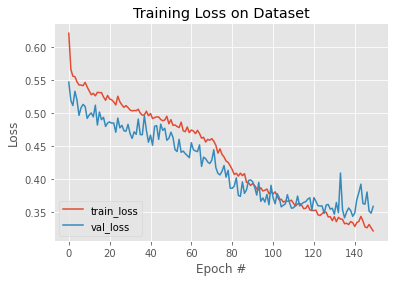

In [9]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)

In [10]:
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

In [12]:
trainLoader.dataset.imagePaths

['..\\cellpose dataset\\train_img\\033_img.png',
 '..\\cellpose dataset\\train_img\\084_img.png',
 '..\\cellpose dataset\\train_img\\177_img.png',
 '..\\cellpose dataset\\train_img\\000_img.png',
 '..\\cellpose dataset\\train_img\\011_img.png',
 '..\\cellpose dataset\\train_img\\472_img.png',
 '..\\cellpose dataset\\train_img\\022_img.png',
 '..\\cellpose dataset\\train_img\\356_img.png',
 '..\\cellpose dataset\\train_img\\090_img.png',
 '..\\cellpose dataset\\train_img\\089_img.png',
 '..\\cellpose dataset\\train_img\\153_img.png',
 '..\\cellpose dataset\\train_img\\277_img.png',
 '..\\cellpose dataset\\train_img\\137_img.png',
 '..\\cellpose dataset\\train_img\\376_img.png',
 '..\\cellpose dataset\\train_img\\131_img.png',
 '..\\cellpose dataset\\train_img\\429_img.png',
 '..\\cellpose dataset\\train_img\\018_img.png',
 '..\\cellpose dataset\\train_img\\280_img.png',
 '..\\cellpose dataset\\train_img\\448_img.png',
 '..\\cellpose dataset\\train_img\\015_img.png',
 '..\\cellpose datas

In [15]:
len(P['x'])

207

In [18]:
len(P['y1'][0][0])

1